In [2]:
pip install xpress networkx matplotlib


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import xpress as xp
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
xp.init("/Users/allanzea/Documents/FICO Xpress Config/xpauth.xpr")
xp.init()

In [5]:
#from google.colab import drive
#drive.mount("/content/drive")

In [6]:
# read the CSV file into a pandas DataFrame
def read_sudoku_csv(file_path):
  df = pd.read_csv(file_path, header = None)
  return df

In [7]:
# example .csv file corresponding to Sudoku puzzle
# sudoku_file_path = "/content/drive/My Drive/TUB Thesis/sudoku_puzzle_example.csv"
sudoku_file_path = "/Users/allanzea/Documents/TUB Thesis/Files/killer_sudoku_puzzle_example.csv"
sudoku_board = read_sudoku_csv(sudoku_file_path)

In [8]:
# define dictionary of killer cages to use
# Source: https://commons.wikimedia.org/wiki/File:Killersudoku_bw.svg
killer_cages = {
    "K1" : ([0, 1], 3),
    "K2" : ([2, 3, 4], 15),
    "K3" : ([5, 13, 14, 22], 22),
    "K4" : ([6, 15], 4),
    "K5" : ([7, 16], 16),
    "K6" : ([8, 17, 26, 35], 15),
    "K7" : ([9, 10, 18, 19], 25),
    "K8" : ([11, 12], 17),
    "K9" : ([20, 21, 30], 9),
    "K10" : ([23, 32, 41], 8),
    "K11" : ([24, 25, 33], 20),
    "K12" : ([27, 36], 6),
    "K13" : ([28, 29], 14),
    "K14" : ([31, 40, 49], 17),
    "K15" : ([34, 42, 43], 17),
    "K16" : ([37, 38, 46], 13),
    "K17" : ([39, 48, 57], 20),
    "K18" : ([44, 53], 12),
    "K19" : ([45, 54, 63, 72], 27),
    "K20" : ([47, 55, 56], 6),
    "K21" : ([50, 59, 60], 20),
    "K22" : ([51, 52], 6),
    "K23" : ([58, 66, 67, 75], 10),
    "K24" : ([61, 62, 70, 71], 14),
    "K25" : ([64, 73], 8),
    "K26" : ([65, 74], 16),
    "K27" : ([68, 69], 15),
    "K28" : ([76, 77, 78], 13),
    "K29" : ([79, 80], 17)
}

In [9]:
class SudokuGraph:

  def __init__(self, board, killer_cages):
    self.board = board
    self.graph = None
    self.grid_size = len(board)
    self.killer_cages = killer_cages
    self.create_sudoku_graph()



  def create_sudoku_graph(self):
    graph = nx.Graph()
    n = self.grid_size

    # create nodes for cells
    for row in range(n):
      for col in range(n):
        value = self.board.iloc[row, col]
        graph.add_node((row, col), value = value)

    # add edges to connect cells within the same row and column
    for row in range(n):
      for col in range(n):
        for i in range(n):
          if i != col:
            graph.add_edge((row, col), (row, i))
          if i != row:
            graph.add_edge((row, col), (i, col))

    # calculate the box size
    box_size = int(n ** 0.5)

    # add edges for the boxs
    for x in range(0, n, box_size):
      for y in range(0, n, box_size):
        for i in range(box_size):
          for j in range(box_size):
            for k in range(box_size):
              for l in range(box_size):
                if (i, j) != (k, l):
                  graph.add_edge((x + i, y + j), (x + k, y + l))

    # remove self-loops from the graph
    graph.remove_edges_from(nx.selfloop_edges(graph))

    # print Sudoku board
    plt.figure(figsize = (5,5))
    plt.title("Sudoku graph\n(board view)")
    pos = {(x,y):(y,-x) for x,y in graph.nodes()}
    nx.draw(graph,
            pos = pos,
            node_color = "orange",
            edgecolors = "black",
            with_labels = False,
            node_size = 400)
    
    # print Sudoku graph
    plt.figure(figsize = (5,5))
    plt.title("Sudoku graph\n(full view)")
    nx.draw(graph, 
            pos = nx.circular_layout(graph),
            node_color = "orange",
            edgecolors = "black",
            node_size = 50)

    # replace labels with numbers
    mapping = {node : index for index, node in enumerate(graph.nodes())}
    graph = nx.relabel_nodes(graph, mapping)

    self.graph = graph


  
  def color(self):
    G = self.graph
    V, E = G.nodes, G.edges
    killer_cages = self.killer_cages

    # create a new problem instance
    p = xp.problem()

    # define bound H on the chromatic number
    n = self.grid_size
    H = n

    # create variable for each node and each potential color
    x = xp.vars(len(V), H, vartype = xp.binary)
    w = np.array([xp.var(vartype = xp.binary) for i in range(H)], dtype = xp.npvar)#.reshape(H,1)

    # add variables to the problem
    p.addVariable(x)
    p.addVariable(w)

    # set the objective
    # p.setObjective(xp.Sum([w[i] for i in range(H)]), sense = xp.minimize)

    # add precoloring constraints
    for v in V:
        # i : initial color of cell
        i = V[v]["value"]
        if i != 0:
            # add precolored nodes to the problem
            p.addConstraint(x[v,i-1] == 1.0)

    # add assignment constraints
    c_1 = [xp.Sum([x[v,i] for i in range(H)]) == 1.0 for v in V]
    c_2 = [x[u,i] + x[v,i] <= w[i] for i in range(H) for u,v in E]
    # add symmetry-breaking constraints
    c_3 = [w[i] <= xp.Sum([x[v,i] for v in V]) for i in range(H)]
    c_4 = [w[i] <= w[i-1] for i in range(1, H)] 
    # add killer constraints
    c_5 = [[xp.Sum([x[v,i] for v in killer_cages[K][0]]) <= w[i] for K in killer_cages] for i in range(H)]
    c_6 = [[xp.Sum([xp.Sum([x[v,i] * (i + 1) for i in range(H)]) for v in killer_cages[K][0]]) == killer_cages[K][1]] for K in killer_cages]

    p.addConstraint(c_1)
    p.addConstraint(c_2)
    p.addConstraint(c_3)
    p.addConstraint(c_4)
    p.addConstraint(c_5)
    p.addConstraint(c_6)

    # optimize problem
    p.optimize()

    # objective = p.getObjVal()
    solution = p.getSolution(x)
    problem_status = p.getProbStatusString()

    # turn solution into a coloring
    coloring = [-1 for v in V]

    chromatic_number = n

    for v in G.nodes:
      for i in range(chromatic_number):
        if p.getSolution(x[v,i]):
          coloring[v] = i + 1

    # print unsolved Sudoku board
    print("\n\nUNSOLVED:")
    self.print_board(self.board)

    # print colored Sudoku (solved) board
    print("\n\nSOLVED:")
    solved_board = np.array(coloring).reshape(self.grid_size, self.grid_size)
    self.print_board(solved_board)

    return coloring, solution, problem_status



  def get_max_degree(self):
    degrees = dict(self.graph.degree())
    print(degrees)
    max_degree = degrees[max(degrees, key = degrees.get)]

    self.plot_graph_degree_stats(self.graph)

    return max_degree
  


  @staticmethod
  def print_board(board):
    board_np = np.array(board)
    n = len(board_np)

    box_size = int(n ** 0.5)

    for row in range(n):
      if row % box_size == 0 and row != 0:
        print("- " * (n + box_size + 1))

      for col in range(n):
        if col % box_size == 0 and col != 0:
          print(" | ", end = " ")

        if col == n - 1:
          if board_np[row][col] == 0:
            print(".")
          else:
            print(board_np[row][col])
        else:
          if board_np[row][col] == 0:
            print("." + " ", end = "")
          else:
            print(str(board_np[row][col]) + " ", end = "")
  


  @staticmethod
  def plot_graph_degree_stats(graph):
    fig, ax1 = plt.subplots(figsize = (10, 2))
    ax1.plot(sorted((d for n, d in graph.degree()), reverse = True), 
             marker = "o", 
             color = "orange",
             markeredgecolor = "black")
    ax1.set_title("Degree distribution")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Vertex")
    plt.show()

Number of vertices:  81
Number of edges:  810


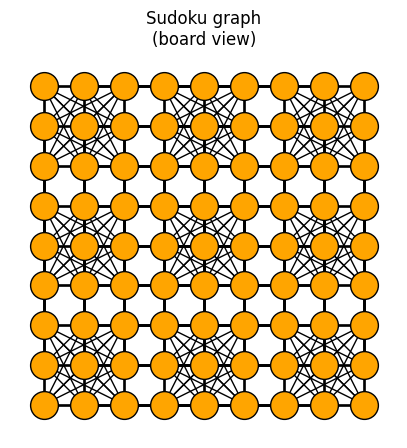

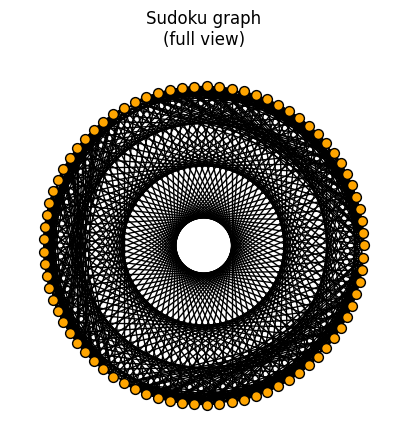

In [10]:
G_sudoku = SudokuGraph(sudoku_board, killer_cages)

print("Number of vertices: ", len(G_sudoku.graph.nodes))
print("Number of edges: ", len(G_sudoku.graph.edges))

{0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20, 16: 20, 17: 20, 18: 20, 19: 20, 20: 20, 21: 20, 22: 20, 23: 20, 24: 20, 25: 20, 26: 20, 27: 20, 28: 20, 29: 20, 30: 20, 31: 20, 32: 20, 33: 20, 34: 20, 35: 20, 36: 20, 37: 20, 38: 20, 39: 20, 40: 20, 41: 20, 42: 20, 43: 20, 44: 20, 45: 20, 46: 20, 47: 20, 48: 20, 49: 20, 50: 20, 51: 20, 52: 20, 53: 20, 54: 20, 55: 20, 56: 20, 57: 20, 58: 20, 59: 20, 60: 20, 61: 20, 62: 20, 63: 20, 64: 20, 65: 20, 66: 20, 67: 20, 68: 20, 69: 20, 70: 20, 71: 20, 72: 20, 73: 20, 74: 20, 75: 20, 76: 20, 77: 20, 78: 20, 79: 20, 80: 20}


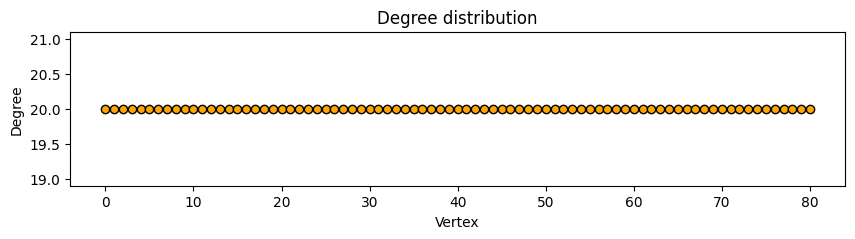

20

In [11]:
G_sudoku.get_max_degree()

In [12]:
coloring, solution, problem_status = G_sudoku.color()

FICO Xpress v9.2.5, Hyper, solve started 19:27:15, Apr 28, 2024
Heap usage: 3364KB (peak 3364KB, 1567KB system)
Minimizing MILP noname using up to 10 threads and up to 32GB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
      7678 rows          738 cols        25072 elements       738 entities
Presolved problem has:
       239 rows          244 cols         1236 elements       244 entities
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 3154KB (peak 6771KB, 1567KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  9.00e+00] / [ 1.25e-01,  1.75e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  2.70e+01] / [ 7.50e-01,  2.75e+00]
  Objective      [min,max] : [      0.0,       0.0] / [      0.0,       0.0]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 30.3GB
 *** Solution found:      .000000   Time:   0.04    Heuristic: e *

In [13]:
print(coloring)

[2, 1, 5, 6, 4, 7, 3, 9, 8, 3, 6, 8, 9, 5, 2, 1, 7, 4, 7, 9, 4, 3, 8, 1, 6, 5, 2, 5, 8, 6, 2, 7, 4, 9, 3, 1, 1, 4, 2, 5, 9, 3, 8, 6, 7, 9, 7, 3, 8, 1, 6, 4, 2, 5, 8, 2, 1, 7, 3, 9, 5, 4, 6, 6, 5, 9, 4, 2, 8, 7, 1, 3, 4, 3, 7, 1, 6, 5, 2, 8, 9]


In [14]:
print(solution[0:5])

[[ 0.  1. -0. -0. -0. -0. -0. -0. -0.]
 [ 1.  0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0.  0.  1. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.  1. -0. -0. -0.]
 [-0. -0. -0.  1. -0. -0. -0. -0. -0.]]


In [15]:
print(problem_status)

mip_optimal


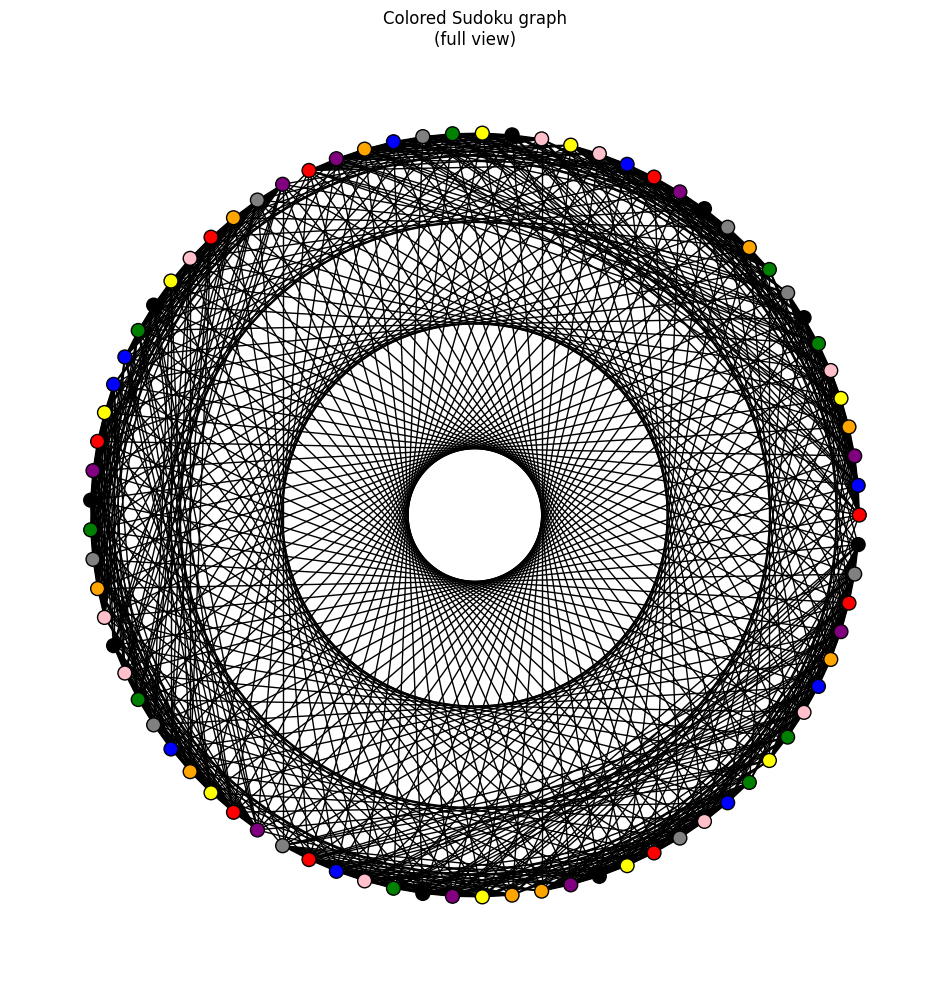

In [16]:
palette = ["blue", "red", "green", "yellow", "purple", "orange", "pink", "grey", "black"]
node_colors = [palette[coloring[i] - 1] for i in G_sudoku.graph.nodes]

plt.figure(figsize = (12,12))
plt.title("Colored Sudoku graph\n(full view)")
nx.draw(G_sudoku.graph,
        pos = nx.circular_layout(G_sudoku.graph),
        node_color = node_colors,
        edgecolors = "black",
        node_size = 100)